In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader


In [2]:
# reload modules
from importlib import reload

from classifier_base import *
from classifier_trans import *
from utils import find_subfolders
from custom_data_loader import load_data

from const import *


In [3]:
import os
import time


cycle_num = 1

time = time.strftime("%Y%m%d%H%M%S", time.localtime())
save_path = r".\outputs" + "\\" + time + "_cycle_" + str(cycle_num)+"all"

# create the directory
try:
    os.makedirs(save_path)
except FileExistsError:
    pass

# choose the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

def train_classifier(model, train_loader, val_loader, epochs=100, lr=0.0001, patience=10, device='cuda'):
    """
    Train a classification model with early stopping based on validation loss.

    Args:
        model (nn.Module): The classification model to train.
        train_loader (DataLoader): DataLoader for training data, yielding (inputs, labels).
        val_loader (DataLoader): DataLoader for validation data, yielding (inputs, labels).
        epochs (int): Maximum number of training epochs.
        lr (float): Learning rate for the optimizer.
        patience (int): Number of epochs to wait for improvement before early stopping.
        device (str): Device to train the model on ('cuda' or 'cpu').

    Returns:
        nn.Module: The trained model with the best validation performance.
        list: Training loss history.
        list: Validation loss history.
        list: Validation accuracy history.
    """
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    best_val_loss = float('inf')
    best_model_wts = None
    epochs_no_improve = 0

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        for batch in train_loader:
            inputs, labels = batch  # Assuming each batch is a tuple (inputs, labels)
            inputs = inputs.to(device).float()
            labels = labels.to(device).long()

            optimizer.zero_grad()
            outputs = model(inputs)  # Outputs are logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation Phase
        model.eval()
        val_running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch
                inputs = inputs.to(device).float()
                labels = labels.to(device).long()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)

                # Calculate accuracy
                _, preds = torch.max(outputs, 1)
                correct_predictions += torch.sum(preds == labels)
                total_predictions += labels.size(0)

        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        epoch_val_accuracy = correct_predictions.double() / total_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy.item())

        print(f"Epoch {epoch + 1}/{epochs}, "
              f"Train Loss: {epoch_train_loss:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, "
              f"Val Accuracy: {epoch_val_accuracy:.4f}")

        # Early Stopping Check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_wts = model.state_dict()
            epochs_no_improve = 0
            print("Validation loss decreased, saving the model...")
        else:
            epochs_no_improve += 1
            print(f"No improvement in validation loss for {epochs_no_improve} epoch(s).")
            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break

    # Load the best model weights
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)

    return model, train_losses, val_losses, val_accuracies


def evaluate_classifier(model, test_loader, device='cuda'):
    """
    Evaluate a classification model on test data.

    Args:
        model (nn.Module): The trained classification model.
        test_loader (DataLoader): DataLoader for test data, yielding (inputs, labels).
        device (str): Device to perform evaluation on ('cuda' or 'cpu').

    Returns:
        float: Mean test loss.
        float: Test accuracy.
        list: List of reconstruction (classification) errors per sample.
        torch.Tensor: Model outputs for the last batch.
    """
    criterion = nn.CrossEntropyLoss()
    model.to(device)
    test_loss = 0.0
    correct = 0
    total = 0
    classification_errors = []
    all_outputs = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch
            inputs = inputs.to(device).float()
            labels = labels.to(device).long()

            outputs = model(inputs)  # [batch_size, num_classes]
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels)
            total += labels.size(0)

            # Collect classification errors (optional)
            # Here, we can define error as 1 - accuracy per sample, but CrossEntropyLoss is not per-sample
            # Alternatively, collect whether each sample was correctly classified
            errors = (preds != labels).float().cpu().numpy()
            classification_errors.extend(errors)

            # Optionally, collect all outputs and labels
            all_outputs.append(outputs.cpu())
            all_labels.append(labels.cpu())

    mean_test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = correct.double() / total
    return mean_test_loss, test_accuracy.item(), classification_errors, torch.cat(all_outputs, dim=0)




In [5]:
root_directory = r"C:\ecg_project\data\data_physionet_2021"
dataset_paths = find_subfolders(root_directory)
print(dataset_paths)

overlap = 1

df_all, period_list = load_data(dataset_paths, max_circle=None,
                        cycle_num=cycle_num, overlap=overlap)  # abnormal or single_abnormal
# print("Data loaded. Datasets loaded: ", loaded_paths_abnormal)
print(f"Number of cycles: {len(df_all)}")


['C:\\ecg_project\\data\\data_physionet_2021\\cpsc_2018', 'C:\\ecg_project\\data\\data_physionet_2021\\cpsc_2018_extra', 'C:\\ecg_project\\data\\data_physionet_2021\\georgia', 'C:\\ecg_project\\data\\data_physionet_2021\\ningbo', 'C:\\ecg_project\\data\\data_physionet_2021\\ptb', 'C:\\ecg_project\\data\\data_physionet_2021\\ptb-xl', 'C:\\ecg_project\\data\\data_physionet_2021\\shaoxing', 'C:\\ecg_project\\data\\data_physionet_2021\\st_petersburg_incart']
Number of records: 37434
Number of cycles: 547692


In [6]:
# Calculate the 33rd and 66th percentiles (the thresholds)
threshold1 = np.percentile(period_list, 33)
threshold2 = np.percentile(period_list, 66)
print(threshold1) # 70 bpm
print(threshold2) # 90 bpm

0.674
0.88


In [7]:
# Assuming period_list is currently a Python list
period_list = np.array(period_list)  # Convert to a NumPy array

# Split the array based on these thresholds
group1 = period_list[period_list < threshold1]  # Group 1: durations below threshold1
group2 = period_list[(period_list >= threshold1) & (period_list < threshold2)]  # Group 2: durations between threshold1 and threshold2
group3 = period_list[period_list >= threshold2]  # Group 3: durations above threshold2

# Print the sizes of the groups
print(len(group1))
print(len(group2))
print(len(group3))

179526
180859
187307


In [8]:
print(df_all.head())

   diagnosis     point_1     point_2     point_3     point_4     point_5  \
0        1.0  310.596325  318.142714  298.889328  265.718802  147.796442   
1        1.0  324.518944  343.161805  335.355156  282.500065  158.620200   
2        1.0  330.868268  350.422330  331.800223  256.369997  108.847214   
3        1.0  307.927962  314.981039  316.798371  240.951320   90.906476   
4        1.0  315.216199  326.870885  320.537358  254.578508  113.343110   

     point_6     point_7     point_8     point_9  ...  point_248  point_249  \
0   9.107703  -74.197893 -131.195598 -179.117776  ... -18.196627 -19.961451   
1  15.297216  -74.186669 -154.989136 -193.687145  ... -50.336155 -39.782114   
2 -24.657939 -111.036467 -178.432538 -195.552342  ... -33.101717 -12.867590   
3 -41.640100 -117.558271 -171.750747 -198.366922  ... -22.857728 -25.831635   
4 -13.359675 -104.843412 -173.457751 -200.770515  ... -44.384432 -32.415211   

   point_250  point_251  point_252  point_253   point_254   point_25

In [9]:
# import pandas as pd
# from itertools import chain
# import torch
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split


# rename_mapping = {
#     '164889003': '164890007'
# }

# # Function to rename diagnosis codes within a list
# def rename_diagnosis_codes(diagnosis_list, mapping):
#     return [mapping.get(code, code) for code in diagnosis_list]

# # Apply the renaming function to the 'diagnosis' column
# df_all['diagnosis'] = df_all['diagnosis'].apply(lambda x: rename_diagnosis_codes(x, rename_mapping))

# # Since diagnosis labels are lists, we'll convert them to tuples for easier counting
# df_all['diagnosis_tuple'] = df_all['diagnosis'].apply(lambda x: tuple(x))

# # Count the number of samples per diagnosis label
# diagnosis_counts = df_all['diagnosis_tuple'].value_counts()

# print(diagnosis_counts)

# # Identify diagnosis labels with at least 20 samples
# valid_diagnoses = diagnosis_counts[diagnosis_counts >= 20].index.tolist()

# # Filter the DataFrame to include only valid diagnosis labels
# df_all = df_all[df_all['diagnosis_tuple'].isin(valid_diagnoses)].copy()

# # Drop the auxiliary 'diagnosis_tuple' column
# df_all.drop(columns=['diagnosis_tuple'], inplace=True)

# # Reset index if desired
# df_all.reset_index(drop=True, inplace=True)

# print(f"Number of records after filtering: {len(df_all)}")

# # Verify the counts after filtering
# final_counts = df_all['diagnosis'].apply(lambda x: tuple(x)).value_counts()
# print(final_counts)



In [10]:
import pandas as pd
from itertools import chain
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Get all unique diagnosis codes
all_codes = set(df_all['diagnosis'])

print(df_all['diagnosis'])

# Map diagnosis codes to integer labels
code_to_label = {code: idx for idx, code in enumerate(sorted(all_codes))}

print(code_to_label)

# Assign labels to the data
df_all['label'] = df_all['diagnosis'].apply(lambda x: code_to_label[x])


0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
547687    5.0
547688    5.0
547689    5.0
547690    5.0
547691    5.0
Name: diagnosis, Length: 547692, dtype: float64
{1.0: 0, 2.0: 1, 3.0: 2, 4.0: 3, 5.0: 4}


In [11]:
print(df_all.head())

   diagnosis     point_1     point_2     point_3     point_4     point_5  \
0        1.0  310.596325  318.142714  298.889328  265.718802  147.796442   
1        1.0  324.518944  343.161805  335.355156  282.500065  158.620200   
2        1.0  330.868268  350.422330  331.800223  256.369997  108.847214   
3        1.0  307.927962  314.981039  316.798371  240.951320   90.906476   
4        1.0  315.216199  326.870885  320.537358  254.578508  113.343110   

     point_6     point_7     point_8     point_9  ...  point_249  point_250  \
0   9.107703  -74.197893 -131.195598 -179.117776  ... -19.961451  -6.613634   
1  15.297216  -74.186669 -154.989136 -193.687145  ... -39.782114  -9.205012   
2 -24.657939 -111.036467 -178.432538 -195.552342  ... -12.867590  -6.856528   
3 -41.640100 -117.558271 -171.750747 -198.366922  ... -25.831635  -5.157757   
4 -13.359675 -104.843412 -173.457751 -200.770515  ... -32.415211 -10.787012   

   point_251  point_252  point_253   point_254   point_255   point_2

In [12]:

# Separate cycles, durations, and labels
# Assuming cycle columns are named as 'point_1', 'point_2', ..., and duration columns are 'cycle_duration_1', 'cycle_duration_2', etc.
cycle_columns = [col for col in df_all.columns if col.startswith('point_')]
duration_columns = [col for col in df_all.columns if col.startswith('cycle_duration_')]

# Combine cycle data and duration as input features
X_cycles = df_all[cycle_columns].values  # Cycle features
X_durations = df_all[duration_columns].values  # Duration features

# Combine cycle and duration into a single feature array
X = np.hstack([X_cycles, X_durations])
y = df_all['label'].values

# Split data into training and test sets (stratify to preserve label distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=23, stratify=y
)

print("Sample of X_train data:\n", X_train[:2])  # Print first two samples for verification


Sample of X_train data:
 [[ 3.61442274e+02  3.56818617e+02  3.44080618e+02  3.21633319e+02
   2.77258506e+02  2.29188674e+02  1.60732581e+02  1.07400001e+02
   7.13456882e+01  3.69610005e+01  6.67489703e+00 -1.84629122e+01
  -1.97290957e+01 -1.24890859e+01 -1.63966040e+01 -1.04889272e+01
  -7.18241077e+00 -2.27331643e+00 -5.29491070e-01  1.48496022e+01
   1.84498500e+01  1.20666044e+01  5.74937745e+00  5.01927075e+00
   6.99634884e+00  6.51609138e+00  3.97274830e+00  1.42647158e+00
  -5.87519020e+00 -7.79813458e+00 -1.03667174e+01 -6.44461501e+00
  -3.82333443e+00 -3.16941844e+00 -3.93599285e+00 -7.37869824e+00
  -1.02447485e+01 -9.22478093e+00 -1.24193132e+01 -1.38288422e+01
  -1.18690465e+01 -8.71265766e+00 -1.61323401e+00 -8.52201616e+00
  -1.46867330e+01 -1.84354820e+01 -2.03948304e+01 -1.53683495e+01
  -2.02100028e+01 -1.81299495e+01 -1.92493103e+01 -1.43045213e+01
  -2.11935276e+01 -2.06610635e+01 -2.22526524e+01 -2.10103716e+01
  -1.61757151e+01 -1.22286450e+01 -1.62187002e+01 -

In [13]:

# Get the number of cycle points and duration columns
num_cycle_points = len(cycle_columns)
num_duration_columns = len(duration_columns)

# Scale the cycle data and duration separately
scaler_cycles = MinMaxScaler()
scaler_durations = MinMaxScaler()

X_train_cycles_scaled = scaler_cycles.fit_transform(X_train[:, :num_cycle_points])  # Scale cycle data
X_train_durations_scaled = scaler_durations.fit_transform(X_train[:, num_cycle_points:])  # Scale duration data

X_test_cycles_scaled = scaler_cycles.transform(X_test[:, :num_cycle_points])
X_test_durations_scaled = scaler_durations.transform(X_test[:, num_cycle_points:])

# Combine scaled cycle and duration features
X_train_scaled = np.hstack([X_train_cycles_scaled, X_train_durations_scaled])
X_test_scaled = np.hstack([X_test_cycles_scaled, X_test_durations_scaled])

# Further split training data into training and validation sets
X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=23, stratify=y_train
)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Optionally, expand dimensions if needed (e.g., for CNN input)
X_train_tensor = X_train_tensor.unsqueeze(1)  # Shape: (batch_size, 1, num_features)
X_val_tensor = X_val_tensor.unsqueeze(1)
X_test_tensor = X_test_tensor.unsqueeze(1)

# Create datasets
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=train_batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=train_batch_size, shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=train_batch_size, shuffle=False
)


In [14]:
# import pandas as pd
# from itertools import chain
# import torch
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split

# # Ensure 'diagnosis' lists are non-empty
# # df_all['diagnosis'] = df_all['diagnosis'].apply(lambda x: x if len(x) > 0 else ['Normal'])

# # Get all unique diagnosis codes
# all_codes = set(chain.from_iterable(df_all['diagnosis']))

# # Map diagnosis codes to integer labels
# code_to_label = {code: idx for idx, code in enumerate(sorted(all_codes))}

# # Assign labels to the data
# df_all['label'] = df_all['diagnosis'].apply(lambda x: code_to_label[x[0]])

# print(code_to_label)

# # Separate cycles, duration, and labels
# # Assuming cycle columns are named as 'point_1', 'point_2', ..., and duration column is 'cycle_duration'
# cycle_columns = [col for col in df_all.columns if col.startswith('point_')]
# duration_column = ['cycle_duration']

# # Combine cycle data and duration as input features
# X_cycles = df_all[cycle_columns].values  # Cycle features
# X_duration = df_all[duration_column].values  # Duration feature

# # Combine cycle and duration into a single feature array
# X = pd.concat([pd.DataFrame(X_cycles), pd.DataFrame(X_duration)], axis=1).values
# y = df_all['label'].values

# # Split data into training and test sets (stratify to preserve label distribution)
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=23, stratify=y
# )

# print(X_train)

# # Scale the cycle data and duration separately
# scaler_cycles = MinMaxScaler()
# scaler_duration = MinMaxScaler()

# X_train_cycles_scaled = scaler_cycles.fit_transform(X_train[:, :-1])  # Scale cycle data
# X_train_duration_scaled = scaler_duration.fit_transform(X_train[:, -1].reshape(-1, 1))  # Scale duration data

# X_test_cycles_scaled = scaler_cycles.transform(X_test[:, :-1])
# X_test_duration_scaled = scaler_duration.transform(X_test[:, -1].reshape(-1, 1))

# # Combine scaled cycle and duration features
# X_train_scaled = pd.concat([pd.DataFrame(X_train_cycles_scaled), pd.DataFrame(X_train_duration_scaled)], axis=1).values
# X_test_scaled = pd.concat([pd.DataFrame(X_test_cycles_scaled), pd.DataFrame(X_test_duration_scaled)], axis=1).values

# # Further split training data into training and validation sets
# X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(
#     X_train_scaled, y_train, test_size=0.2, random_state=23, stratify=y_train
# )

# # Convert to PyTorch tensors
# X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.long)

# X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
# y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# # Optionally, expand dimensions if needed (e.g., for CNN input)
# X_train_tensor = X_train_tensor.unsqueeze(1)  # Shape: (batch_size, 1, num_features)
# X_val_tensor = X_val_tensor.unsqueeze(1)
# X_test_tensor = X_test_tensor.unsqueeze(1)

# # Create datasets
# train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
# val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
# test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

# # Create DataLoaders
# train_batch_size = 64
# train_loader = torch.utils.data.DataLoader(
#     train_dataset, batch_size=train_batch_size, shuffle=True
# )
# val_loader = torch.utils.data.DataLoader(
#     val_dataset, batch_size=train_batch_size, shuffle=False
# )
# test_loader = torch.utils.data.DataLoader(
#     test_dataset, batch_size=train_batch_size, shuffle=False
# )


Training data shape: (438153, 257)
Validation data shape: (87631, 257)
Test data shape: (109539, 257)
Training labels distribution:
Label 0: 145866 samples
Label 1: 107908 samples
Label 2: 42760 samples
Label 3: 43882 samples
Label 4: 10106 samples

Validation labels distribution:
Label 0: 36467 samples
Label 1: 26977 samples
Label 2: 10690 samples
Label 3: 10971 samples
Label 4: 2526 samples

Test labels distribution:
Label 0: 45583 samples
Label 1: 33722 samples
Label 2: 13363 samples
Label 3: 13713 samples
Label 4: 3158 samples

Plotting first 5 ECG signals from the training set:


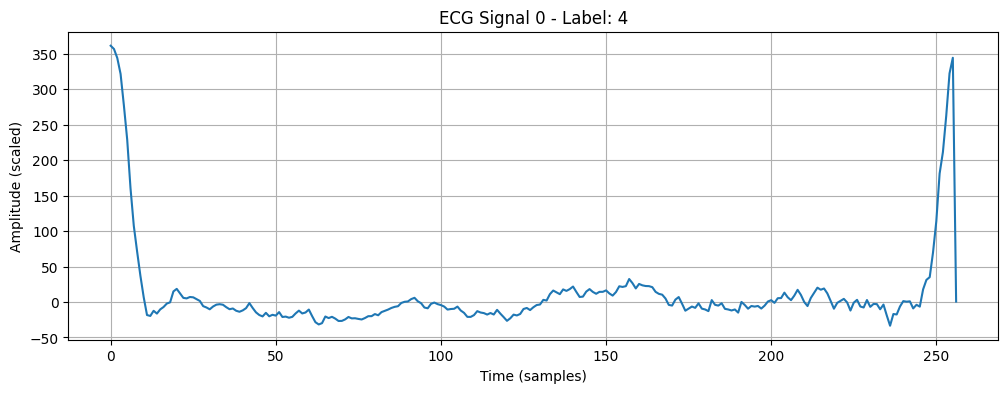

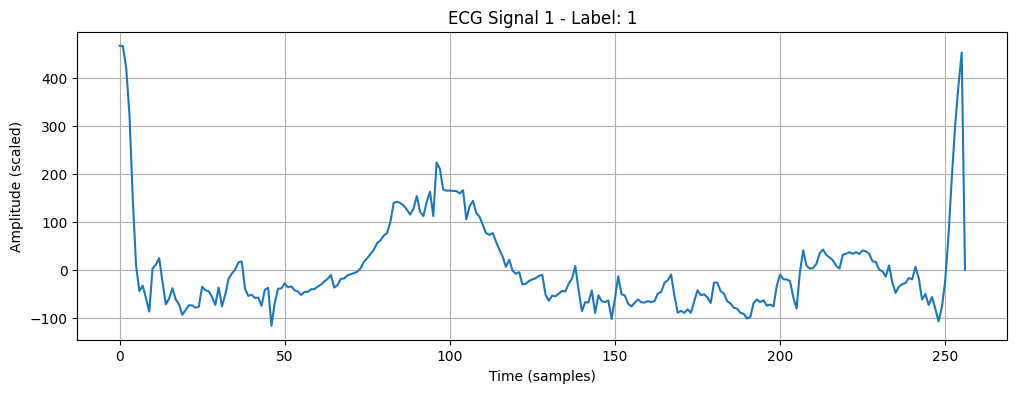

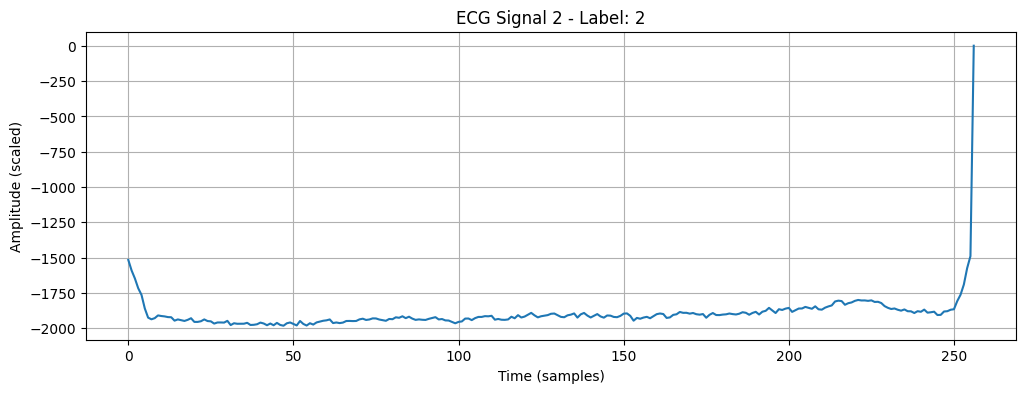

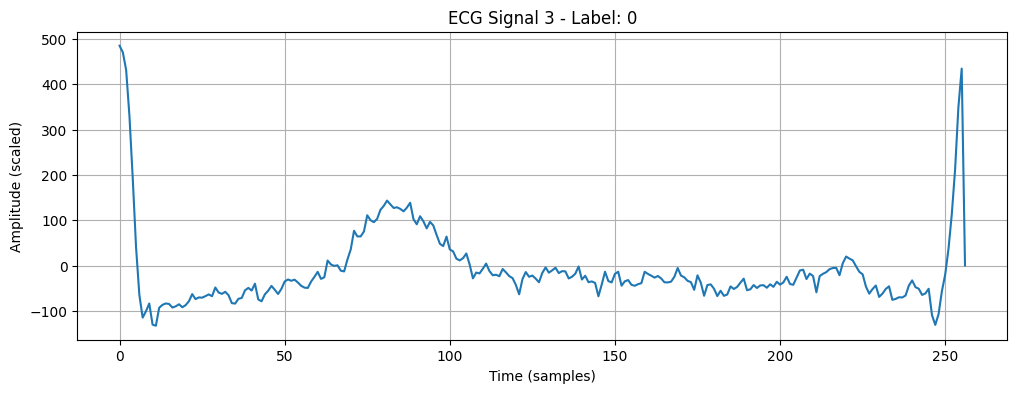

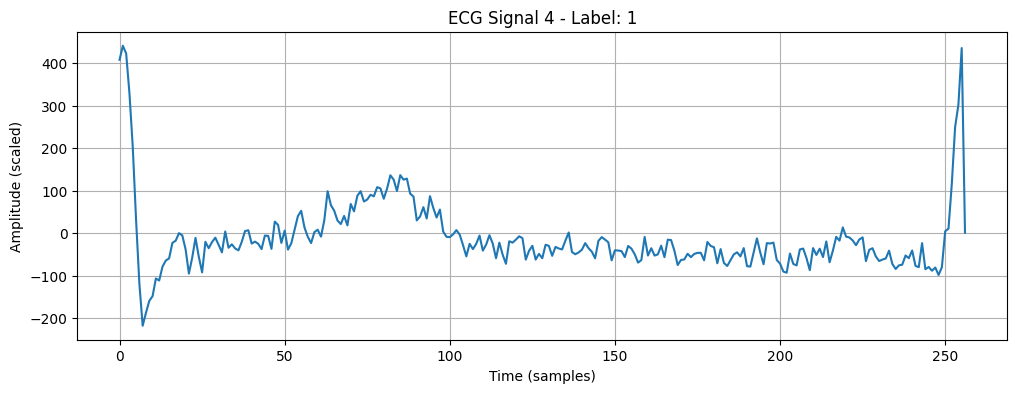

Plotting first 5 ECG signals from the test set:


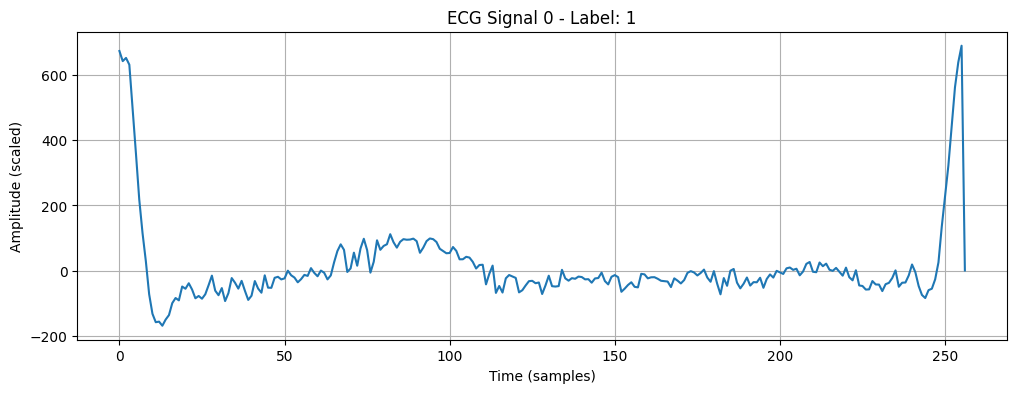

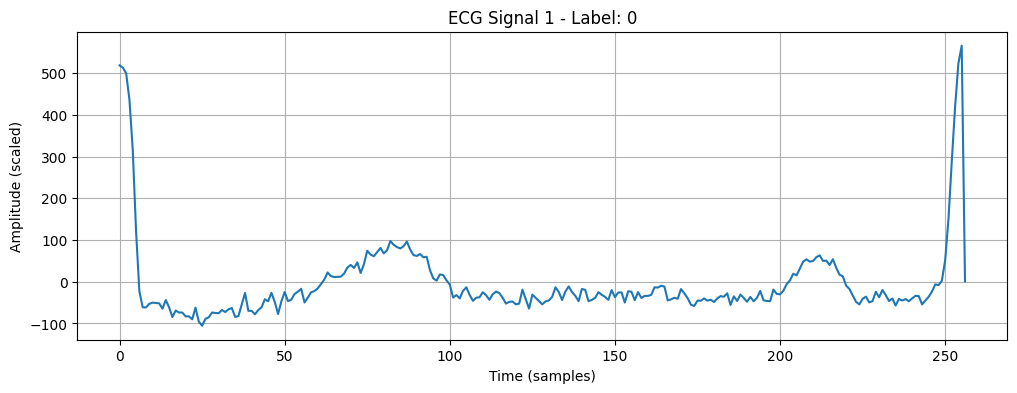

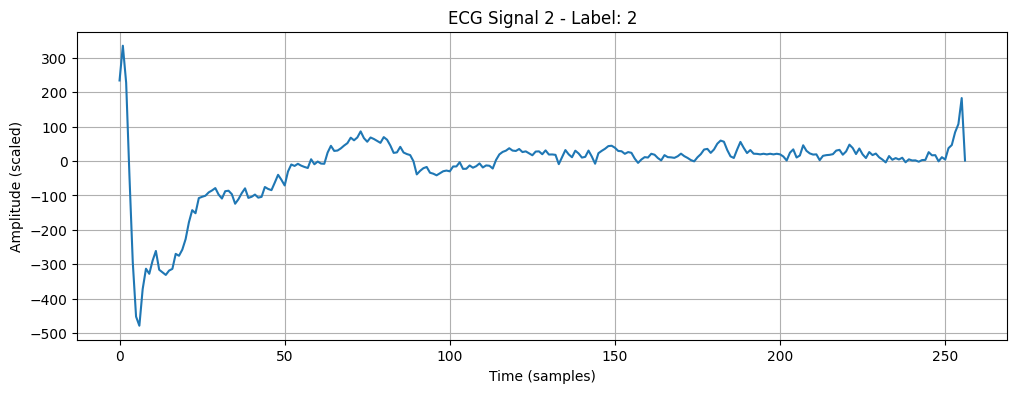

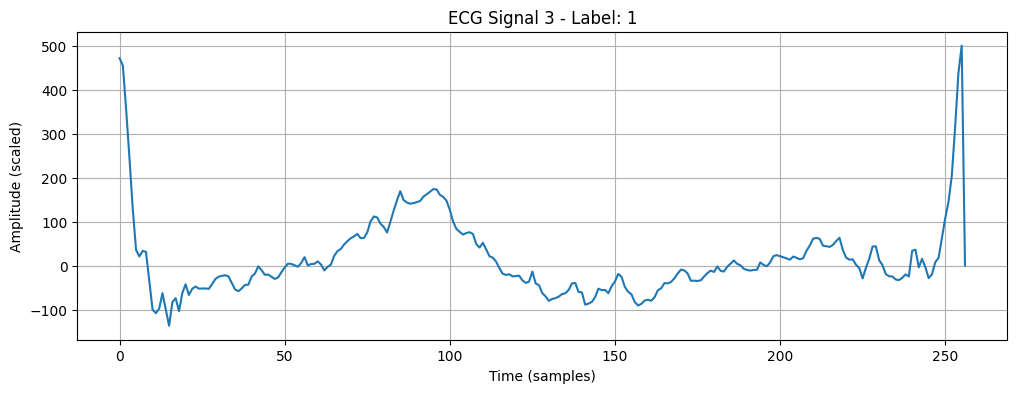

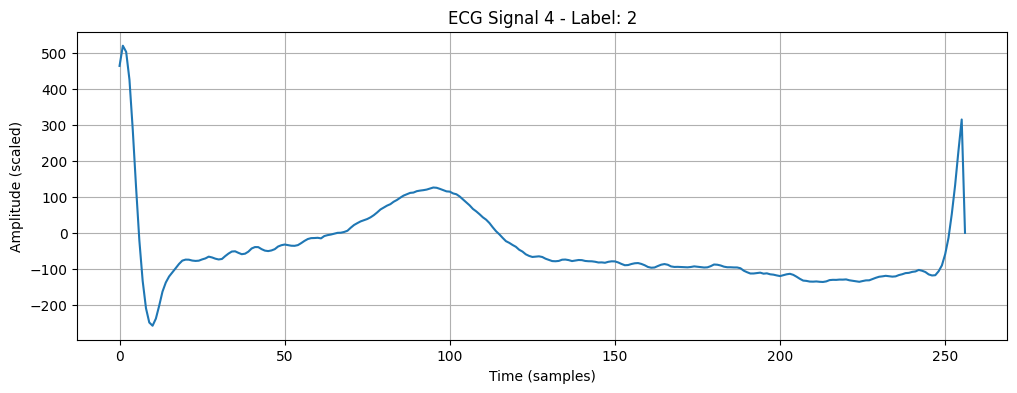

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Print shapes of the datasets
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val_scaled.shape)
print("Test data shape:", X_test.shape)

# Print label distributions
unique, counts = np.unique(y_train, return_counts=True)
print("Training labels distribution:")
for label, count in zip(unique, counts):
    print(f"Label {label}: {count} samples")

unique, counts = np.unique(y_val, return_counts=True)
print("\nValidation labels distribution:")
for label, count in zip(unique, counts):
    print(f"Label {label}: {count} samples")

unique, counts = np.unique(y_test, return_counts=True)
print("\nTest labels distribution:")
for label, count in zip(unique, counts):
    print(f"Label {label}: {count} samples")

# Function to plot an ECG signal
def plot_ecg(signal, label, idx):
    
    plt.figure(figsize=(12, 4))
    plt.plot(signal)
    plt.title(f"ECG Signal {idx} - Label: {label}")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude (scaled)")
    plt.grid(True)
    plt.show()

# Plot first 5 samples from the training data
print("\nPlotting first 5 ECG signals from the training set:")
for i in range(5):
    signal = X_train[i]
    label = y_train[i]
    plot_ecg(signal, label, i)

# Plot first 5 samples from the test data
print("Plotting first 5 ECG signals from the test set:")
for i in range(5):
    signal = X_test[i]
    label = y_test[i]
    plot_ecg(signal, label, i)


In [16]:
# attention cnn
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    """
    A Residual Block as introduced in ResNet.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.elu = nn.ELU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample
        self.se = SELayer(out_channels)  # Squeeze-and-Excitation

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.elu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)  # Apply SE block

        if self.downsample:
            identity = self.downsample(x)

        out += identity
        out = self.elu(out)

        return out


class SELayer(nn.Module):
    """
    Squeeze-and-Excitation (SE) block.
    """
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.fc1 = nn.Linear(channel, channel // reduction, bias=False)
        self.fc2 = nn.Linear(channel // reduction, channel, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Squeeze
        b, c, _ = x.size()
        y = F.adaptive_avg_pool1d(x, 1).view(b, c)
        # Excitation
        y = self.fc1(y)
        y = F.relu(y, inplace=True)
        y = self.fc2(y)
        y = self.sigmoid(y).view(b, c, 1)
        # Scale
        return x * y.expand_as(x)


class GlobalAttention(nn.Module):
    """
    Global Attention mechanism that takes into account both ECG and duration features.
    """
    def __init__(self, ecg_feature_size, duration_feature_size, intermediate_size=128):
        super(GlobalAttention, self).__init__()
        self.fc1 = nn.Linear(ecg_feature_size + duration_feature_size, intermediate_size, bias=False)
        self.elu = nn.ELU(inplace=True)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(intermediate_size, ecg_feature_size, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, ecg_features, duration_features):
        """
        Args:
            ecg_features (torch.Tensor): Shape [batch_size, ecg_feature_size]
            duration_features (torch.Tensor): Shape [batch_size, duration_feature_size]
        
        Returns:
            torch.Tensor: Attention weights of shape [batch_size, ecg_feature_size]
        """
        combined = torch.cat((ecg_features, duration_features), dim=-1)  # [batch_size, ecg + duration]
        y = self.fc1(combined)  # [batch_size, intermediate_size]
        y = self.elu(y)
        y = self.dropout(y)
        y = self.fc2(y)  # [batch_size, ecg_feature_size]
        y = self.sigmoid(y)  # [batch_size, ecg_feature_size]
        return y


class AttentionConvFcClassifier(nn.Module):
    def __init__(self, num_classes=3, target_length=32, cycle_num=2):
        """
        Enhanced ConvFcClassifier with Residual Blocks, SE layers, and Global Attention.

        Args:
            num_classes (int): Number of target classes for classification.
            target_length (int): The desired sequence length after adaptive pooling.
            cycle_num (int): Number of ECG cycles per sample.
        """
        super(AttentionConvFcClassifier, self).__init__()
        
        self.cycle_num = cycle_num
        self.cycle_length = 256  # Assuming fixed length of each cycle

        # Initial Convolution for ECG Data
        self.initial_conv = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=8*cycle_num, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm1d(8*cycle_num),
            nn.ELU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )
        
        # Residual Layers for ECG Data
        self.layer1 = self._make_layer(8*cycle_num, 16*cycle_num, blocks=2, stride=2)
        self.layer2 = self._make_layer(16*cycle_num, 32*cycle_num, blocks=2, stride=2)
        self.layer3 = self._make_layer(32*cycle_num, 64*cycle_num, blocks=2, stride=2)
        
        # Adaptive Pooling for ECG Data
        self.adaptive_pool = nn.AdaptiveAvgPool1d(target_length)
        
        # Global Context Attention for ECG Data and Duration
        # The attention now takes into account both ECG and duration features
        # ECG features size after adaptive pooling: 64*cycle_num * target_length
        # Duration features size after projection: 64*cycle_num
        self.global_attention = GlobalAttention(
            ecg_feature_size=64*cycle_num * target_length,
            duration_feature_size=64*cycle_num,
            intermediate_size=128*cycle_num
        )
        
        # Projection Layer for Duration Feature
        self.duration_projection = nn.Sequential(
            nn.Linear(cycle_num, 64 * cycle_num),
            nn.BatchNorm1d(64 * cycle_num),
            nn.ELU(inplace=True),
            nn.Dropout(0.5)
        )
        
        # Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(64*cycle_num * target_length + 64*cycle_num, 64*cycle_num),
            nn.BatchNorm1d(64*cycle_num),
            nn.ELU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64*cycle_num, 32*cycle_num),
            nn.BatchNorm1d(32*cycle_num),
            nn.ELU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(32*cycle_num, num_classes)  # Output layer without activation (logits)
        )

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        """
        Creates a layer consisting of Residual Blocks.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            blocks (int): Number of Residual Blocks.
            stride (int): Stride for the first block.

        Returns:
            nn.Sequential: A sequential container of Residual Blocks.
        """
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride=stride, downsample=downsample))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)


    def forward(self, x):
        """
        Forward pass of the ConvFcClassifier.

        Args:
            x (torch.Tensor): Input tensor of shape [batch_size, 1, sequence_length]

        Returns:
            torch.Tensor: Logits tensor of shape [batch_size, num_classes]
        """
        # Split the input into ECG cycles and duration
        # Assuming the last dimension is the sequence length, and duration is a separate feature
        # Modify this part based on the actual input format
        # Here, we assume that the duration is the last value in the sequence
        ecg_data = x[:, :, :-self.cycle_num]  # All cycles data
        duration = x[:, :, -self.cycle_num:]    # Duration feature, shape: [batch_size, 1]
        duration = duration.squeeze(1)
        

        # Reshape ECG data to have shape (batch_size, 1, cycles_length * cycle_num)
        # ecg_data = ecg_data.view(ecg_data.size(0), 1, -1)


        # Convolutional layers for ECG data
        ecg_features = self.initial_conv(ecg_data)
        

        ecg_features = self.layer1(ecg_features)
        ecg_features = self.layer2(ecg_features)
        ecg_features = self.layer3(ecg_features)
        ecg_features = self.adaptive_pool(ecg_features)  # Shape: [batch_size, 64*cycle_num, target_length]

        # Flatten the ECG feature map
        ecg_flat = ecg_features.view(ecg_features.size(0), -1)  # Shape: [batch_size, 64*cycle_num * target_length]

        # Project duration feature
        duration_proj = self.duration_projection(duration).squeeze(-1)  # Shape: [batch_size, 64*cycle_num]

        # Compute attention weights using both ECG and duration features
        attention_weights = self.global_attention(ecg_flat, duration_proj)  # Shape: [batch_size, 64*cycle_num * target_length]

        attention_weights = attention_weights.view(ecg_features.size(0), 64*self.cycle_num, -1)  # Shape: [batch_size, 64*cycle_num, target_length]
        ecg_features = ecg_features * attention_weights  # Apply attention

        # Flatten after attention
        ecg_flat = ecg_features.view(ecg_features.size(0), -1)  # Shape: [batch_size, 64*cycle_num * target_length]

        # Concatenate ECG features with projected duration
        combined_features = torch.cat((ecg_flat, duration_proj), dim=-1)  # Shape: [batch_size, 64*cycle_num * target_length + 64*cycle_num]

        # Classification head
        out = self.classifier(combined_features)  # Shape: [batch_size, num_classes]

        return out

In [17]:
# ConvFcClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    """
    A Residual Block as introduced in ResNet.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.elu = nn.ELU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample
        self.se = SELayer(out_channels)  # Squeeze-and-Excitation

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.elu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)  # Apply SE block

        if self.downsample:
            identity = self.downsample(x)

        out += identity
        out = self.elu(out)

        return out


class SELayer(nn.Module):
    """
    Squeeze-and-Excitation (SE) block.
    """
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.fc1 = nn.Linear(channel, channel // reduction, bias=False)
        self.fc2 = nn.Linear(channel // reduction, channel, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Squeeze
        b, c, _ = x.size()
        y = F.adaptive_avg_pool1d(x, 1).view(b, c)
        # Excitation
        y = self.fc1(y)
        y = F.relu(y, inplace=True)
        y = self.fc2(y)
        y = self.sigmoid(y).view(b, c, 1)
        # Scale
        return x * y.expand_as(x)


class ConvFcClassifier(nn.Module):
    def __init__(self, num_classes=3, target_length=32, cycle_num=2):
        """
        Enhanced ConvFcClassifier with Residual Blocks and SE layers.

        Args:
            num_classes (int): Number of target classes for classification.
            target_length (int): The desired sequence length after adaptive pooling.
            cycle_num (int): Number of ECG cycles per sample.
        """
        super(ConvFcClassifier, self).__init__()
        
        self.cycle_num = cycle_num
        self.cycle_length = 256  # Assuming fixed length of each cycle

        # Initial Convolution for ECG Data
        self.initial_conv = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=8*cycle_num, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm1d(8*cycle_num),
            nn.ELU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )
        
        # Residual Layers for ECG Data
        self.layer1 = self._make_layer(8*cycle_num, 16*cycle_num, blocks=2, stride=2)
        self.layer2 = self._make_layer(16*cycle_num, 32*cycle_num, blocks=2, stride=2)
        self.layer3 = self._make_layer(32*cycle_num, 64*cycle_num, blocks=2, stride=2)
        
        # Adaptive Pooling for ECG Data
        self.adaptive_pool = nn.AdaptiveAvgPool1d(target_length)
        
        # Projection Layer for Duration Feature
        self.duration_projection = nn.Sequential(
            nn.Linear(cycle_num, 64 * cycle_num),
            nn.BatchNorm1d(64 * cycle_num),
            nn.ELU(inplace=True),
            nn.Dropout(0.5)
        )
        
        # Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(64*cycle_num * target_length + 64*cycle_num, 64*cycle_num),
            nn.BatchNorm1d(64*cycle_num),
            nn.ELU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64*cycle_num, 32*cycle_num),
            nn.BatchNorm1d(32*cycle_num),
            nn.ELU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(32*cycle_num, num_classes)  # Output layer without activation (logits)
        )

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        """
        Creates a layer consisting of Residual Blocks.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            blocks (int): Number of Residual Blocks.
            stride (int): Stride for the first block.

        Returns:
            nn.Sequential: A sequential container of Residual Blocks.
        """
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride=stride, downsample=downsample))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)


    def forward(self, x):
        """
        Forward pass of the ConvFcClassifier.

        Args:
            x (torch.Tensor): Input tensor of shape [batch_size, 1, sequence_length]

        Returns:
            torch.Tensor: Logits tensor of shape [batch_size, num_classes]
        """
        # Split the input into ECG cycles and duration
        # Assuming the last element in the sequence is the duration feature
        ecg_data = x[:, :, :-self.cycle_num]  # All cycles data
        duration = x[:, :, -self.cycle_num:]    # Duration feature, shape: [batch_size, 1]

        # Reshape ECG data to have shape (batch_size, 1, cycles_length * cycle_num)
        # ecg_data = ecg_data.view(ecg_data.size(0), 1, -1)
        duration = duration.squeeze(1)

        # Convolutional layers for ECG data
        ecg_features = self.initial_conv(ecg_data)
        ecg_features = self.layer1(ecg_features)
        ecg_features = self.layer2(ecg_features)
        ecg_features = self.layer3(ecg_features)
        ecg_features = self.adaptive_pool(ecg_features)  # Shape: [batch_size, 64*cycle_num, target_length]

        # Flatten the ECG feature map
        ecg_flat = ecg_features.view(ecg_features.size(0), -1)  # Shape: [batch_size, 64*cycle_num * target_length]

        # Project duration feature
        duration_proj = self.duration_projection(duration).squeeze(-1)  # Shape: [batch_size, 64*cycle_num]

        # Concatenate ECG features with projected duration
        combined_features = torch.cat((ecg_flat, duration_proj), dim=-1)  # Shape: [batch_size, 64*cycle_num * target_length + 64*cycle_num]

        # Classification head
        out = self.classifier(combined_features)  # Shape: [batch_size, num_classes]

        return out


In [18]:
# LightweightConvFcClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    """
    A Residual Block as introduced in ResNet.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.elu = nn.ELU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.elu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            identity = self.downsample(x)

        out += identity
        out = self.elu(out)

        return out

class LightweightConvFcClassifier(nn.Module):
    def __init__(self, num_classes=3, target_length=32, cycle_num=2):
        """
        Enhanced ConvFcClassifier with Residual Blocks.

        Args:
            num_classes (int): Number of target classes for classification.
            target_length (int): The desired sequence length after adaptive pooling.
            cycle_num (int): Number of ECG cycles per sample.
        """
        super(LightweightConvFcClassifier, self).__init__()
        
        self.cycle_num = cycle_num
        self.cycle_length = 256  # Assuming fixed length of each cycle

        # Initial Convolution for ECG Data
        self.initial_conv = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=8*cycle_num, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm1d(8*cycle_num),
            nn.ELU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )
        
        # Residual Layers for ECG Data
        self.layer1 = self._make_layer(8*cycle_num, 16*cycle_num, blocks=2, stride=2)
        self.layer2 = self._make_layer(16*cycle_num, 32*cycle_num, blocks=2, stride=2)
        self.layer3 = self._make_layer(32*cycle_num, 64*cycle_num, blocks=2, stride=2)
        
        # Adaptive Pooling for ECG Data
        self.adaptive_pool = nn.AdaptiveAvgPool1d(target_length)
        
        # Projection Layer for Duration Feature
        self.duration_projection = nn.Sequential(
            nn.Linear(cycle_num, 64 * cycle_num),
            nn.BatchNorm1d(64 * cycle_num),
            nn.ELU(inplace=True),
            nn.Dropout(0.5)
        )
        
        # Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(64*cycle_num * target_length + 64*cycle_num, 64*cycle_num),
            nn.BatchNorm1d(64*cycle_num),
            nn.ELU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64*cycle_num, 32*cycle_num),
            nn.BatchNorm1d(32*cycle_num),
            nn.ELU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(32*cycle_num, num_classes)  # Output layer without activation (logits)
        )

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        """
        Creates a layer consisting of Residual Blocks.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            blocks (int): Number of Residual Blocks.
            stride (int): Stride for the first block.

        Returns:
            nn.Sequential: A sequential container of Residual Blocks.
        """
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride=stride, downsample=downsample))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)


    def forward(self, x):
        """
        Forward pass of the ConvFcClassifier.

        Args:
            x (torch.Tensor): Input tensor of shape [batch_size, 1, sequence_length]

        Returns:
            torch.Tensor: Logits tensor of shape [batch_size, num_classes]
        """
        # Split the input into ECG cycles and duration
        # Assuming the last element in the sequence is the duration feature
        ecg_data = x[:, :, :-self.cycle_num]  # All cycles data
        duration = x[:, :, -self.cycle_num:]    # Duration feature, shape: [batch_size, 1]

        # Reshape ECG data to have shape (batch_size, 1, cycles_length * cycle_num)
        # ecg_data = ecg_data.view(ecg_data.size(0), 1, -1)
        duration = duration.squeeze(1)

        # Convolutional layers for ECG data
        ecg_features = self.initial_conv(ecg_data)
        ecg_features = self.layer1(ecg_features)
        ecg_features = self.layer2(ecg_features)
        ecg_features = self.layer3(ecg_features)
        ecg_features = self.adaptive_pool(ecg_features)  # Shape: [batch_size, 64*cycle_num, target_length]

        # Flatten the ECG feature map
        ecg_flat = ecg_features.view(ecg_features.size(0), -1)  # Shape: [batch_size, 64*cycle_num * target_length]

        # Project duration feature
        duration_proj = self.duration_projection(duration).squeeze(-1)  # Shape: [batch_size, 64*cycle_num]

        # Concatenate ECG features with projected duration
        combined_features = torch.cat((ecg_flat, duration_proj), dim=-1)  # Shape: [batch_size, 64*cycle_num * target_length + 64*cycle_num]

        # Classification head
        out = self.classifier(combined_features)  # Shape: [batch_size, num_classes]

        return out


In [19]:
# Define model parameters
num_classes = len(code_to_label)  # Number of target classes
target_length = cycle_num * 8


# Initialize Classifier Models
conv_fc_classifier = ConvFcClassifier(num_classes=num_classes, target_length=target_length, cycle_num=cycle_num).to(device)
atten_conv_fc_classifier = AttentionConvFcClassifier(num_classes=num_classes, target_length=target_length, cycle_num=cycle_num).to(device)
light_conv_fc_classifier = LightweightConvFcClassifier(num_classes=num_classes, target_length=cycle_num * 4, cycle_num=cycle_num-1).to(device)

c:\Python312\Lib\site-packages\torch\nn\init.py:453: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [20]:

# # Define model parameters
# num_classes = len(code_to_label)  # Number of target classes
# target_length = cycle_num * 8


# # Initialize Classifier Models
# conv_fc_classifier = DenseClassifier(num_classes=num_classes).to(device)
# atten_conv_fc_classifier = AttentionLSTMClassifier(256, 4, num_classes).to(device)
# light_conv_fc_classifier = AttentionLSTMClassifier(128, 2, num_classes).to(device)


In [21]:


# print("Training ConvFc Classifier...")
# conv_fc_classifier, train_losses_conv_fc, val_losses_conv_fc, val_accuracies_conv_fc = train_classifier(
#     model=conv_fc_classifier, 
#     train_loader=train_loader, 
#     val_loader=val_loader, 
#     epochs=500, 
#     patience=50, 
#     lr=0.00005, 
#     device=device
# )

# print("Training Lightweight ConvFc Classifier...")
# light_conv_fc_classifier, light_train_losses_conv_fc, light_val_losses_conv_fc, light_val_accuracies_conv_fc = train_classifier(
#     model=light_conv_fc_classifier, 
#     train_loader=train_loader, 
#     val_loader=val_loader, 
#     epochs=500, 
#     patience=50, 
#     lr=0.00005, 
#     device=device
# )

print("Training Attention ConvFc Classifier...")
atten_conv_fc_classifier, atten_train_losses_conv_fc, atten_val_losses_conv_fc, atten_val_accuracies_conv_fc = train_classifier(
    model=atten_conv_fc_classifier, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    epochs=500, 
    patience=50, 
    lr=0.00005, 
    device=device
)



Training Attention ConvFc Classifier...
Epoch 1/500, Train Loss: 1.1068, Val Loss: 0.9203, Val Accuracy: 0.6650
Validation loss decreased, saving the model...
Epoch 2/500, Train Loss: 0.8995, Val Loss: 0.7769, Val Accuracy: 0.7200
Validation loss decreased, saving the model...
Epoch 3/500, Train Loss: 0.8324, Val Loss: 0.7284, Val Accuracy: 0.7432
Validation loss decreased, saving the model...
Epoch 4/500, Train Loss: 0.8002, Val Loss: 0.7115, Val Accuracy: 0.7480
Validation loss decreased, saving the model...
Epoch 5/500, Train Loss: 0.7774, Val Loss: 0.6809, Val Accuracy: 0.7614
Validation loss decreased, saving the model...
Epoch 6/500, Train Loss: 0.7594, Val Loss: 0.6938, Val Accuracy: 0.7556
No improvement in validation loss for 1 epoch(s).
Epoch 7/500, Train Loss: 0.7436, Val Loss: 0.6638, Val Accuracy: 0.7624
Validation loss decreased, saving the model...
Epoch 8/500, Train Loss: 0.7313, Val Loss: 0.6375, Val Accuracy: 0.7745
Validation loss decreased, saving the model...
Epoch

In [22]:
def plot_training_history(train_losses, val_losses, val_accuracies, model_name):
    """
    Plots the training and validation loss and validation accuracy.

    Args:
        train_losses (list): List of training losses per epoch.
        val_losses (list): List of validation losses per epoch.
        val_accuracies (list): List of validation accuracies per epoch.
        model_name (str): Name of the model for labeling.
    """
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, 'g-', label='Validation Accuracy')
    plt.title(f'{model_name} - Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


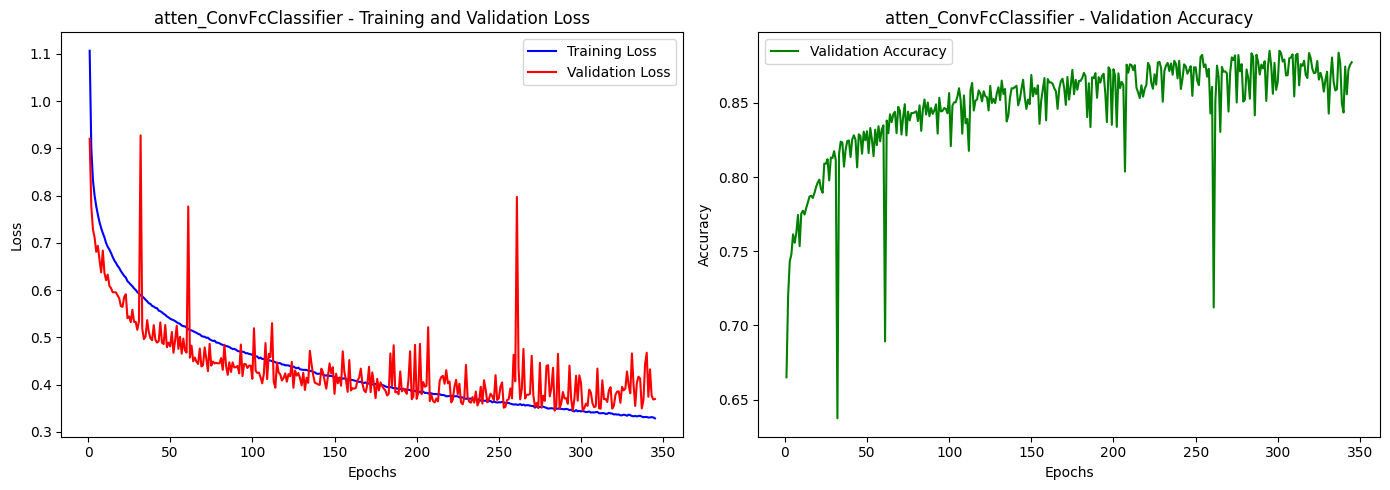

In [23]:
# plot_training_history(
#     train_losses=light_train_losses_conv_fc,
#     val_losses=light_val_losses_conv_fc,
#     val_accuracies=light_val_accuracies_conv_fc,
#     model_name='light_ConvFcClassifier'
# )

plot_training_history(
    train_losses=atten_train_losses_conv_fc,
    val_losses=atten_val_losses_conv_fc,
    val_accuracies=atten_val_accuracies_conv_fc,
    model_name='atten_ConvFcClassifier'
)

# plot_training_history(
#     train_losses=train_losses_conv_fc,
#     val_losses=val_losses_conv_fc,
#     val_accuracies=val_accuracies_conv_fc,
#     model_name='ConvFcClassifier'
# )



In [24]:

# Evaluate ConvFcClassifier
atten_mean_test_loss_conv_fc, atten_test_accuracy_conv_fc, atten_classification_errors_conv_fc, atten_outputs_conv_fc = evaluate_classifier(
    model=atten_conv_fc_classifier,
    test_loader=test_loader,
    device=device
)
print(f"atten_ConvFcClassifier - Test Loss: {atten_mean_test_loss_conv_fc:.4f}, Test Accuracy: {atten_test_accuracy_conv_fc:.4f}")


# light_mean_test_loss_conv_fc, light_test_accuracy_conv_fc, light_classification_errors_conv_fc, light_outputs_conv_fc = evaluate_classifier(
#     model=light_conv_fc_classifier,
#     test_loader=test_loader,
#     device=device
# )
# print(f"light_ConvFcClassifier - Test Loss: {light_mean_test_loss_conv_fc:.4f}, Test Accuracy: {light_test_accuracy_conv_fc:.4f}")


# mean_test_loss_conv_fc, test_accuracy_conv_fc, classification_errors_conv_fc, outputs_conv_fc = evaluate_classifier(
#     model=conv_fc_classifier,
#     test_loader=test_loader,
#     device=device
# )
# print(f"ConvFcClassifier - Test Loss: {mean_test_loss_conv_fc:.4f}, Test Accuracy: {test_accuracy_conv_fc:.4f}")



atten_ConvFcClassifier - Test Loss: 0.3726, Test Accuracy: 0.8749


In [25]:
# torch.save(attention_lstm_classifier.state_dict(), './models/4AttentionLSTMClassifier.pth')
# torch.save(conv_fc_classifier.state_dict(), f'./models/{cycle_num}ConvFcClassifier.pth')
torch.save(atten_conv_fc_classifier.state_dict(), f'./models/{cycle_num}attenConvFcClassifier.pth')
# torch.save(light_conv_fc_classifier.state_dict(), f'./models/{cycle_num}lightConvFcClassifier.pth')
# torch.save(dense_classifier.state_dict(), './models/4DenseClassifier.pth')

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd  # Import pandas to handle CSV writing
import torch

def generate_reports(true_labels, predicted_labels, model_name, report_file):
    """
    Generates and writes classification report to a file and confusion matrix to a CSV file.

    Args:
        true_labels (numpy.ndarray): True labels.
        predicted_labels (numpy.ndarray): Predicted labels predicted by the model.
        model_name (str): Name of the model for labeling.
        report_file (file object): Open file to write the report.
    """
    # Write model name header
    report_file.write(f"\n--- {model_name} ---\n\n")
    
    # Combine true and predicted labels to get all labels present in the data
    unique_labels = np.unique(np.concatenate((true_labels, predicted_labels)))
    labels = sorted(unique_labels)
    
    # Invert code_to_label to get label_to_disease mapping
    label_to_disease = {v: k for k, v in code_to_label.items()}
    
    print("Unique labels in data:", labels)
    print("label_to_disease:", label_to_disease)
    
    # Ensure all labels are in label_to_disease
    missing_labels = [label for label in labels if label not in label_to_disease]
    if missing_labels:
        print("The following labels are missing in label_to_disease:", missing_labels)
        # Handle missing labels by adding them with a default name
        for label in missing_labels:
            label_to_disease[label] = f"Unknown Label {label}"
    
    # Generate target_names for labels present in data
    # target_names = [label_to_disease.get(k, f"Label {k}") for k in labels]
    print(true_labels)
    print(predicted_labels)
    print(labels)
    # print(target_names)
    # Generate classification report
    report = classification_report(
        true_labels,
        predicted_labels,
        labels=labels,
        # target_names=target_names,
        zero_division=0
    )
    report_file.write("Classification Report:\n")
    report_file.write(report + "\n")
    
    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=labels)
    
    # Write confusion matrix to a CSV file
    csv_file_path = save_path + f"/{model_name}_confusion_matrix.csv"  # Ensure save_path is defined
    # Convert confusion matrix to DataFrame
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    cm_df.to_csv(csv_file_path, encoding='utf-8')
    
    # Optionally, save the confusion matrix as an image
    plt.figure(figsize=(4,4))  # Adjust size to accommodate the number of classes
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.tight_layout()
    plt.savefig(save_path + f"/{model_name}_confusion_matrix.png")
    plt.close()

# Open a text file in write mode
with open(save_path + "/confusion_matrices.txt", "w") as f:
    # Retrieve true labels from test_dataset
    true_labels = test_dataset.tensors[1].numpy()
    
    # ConvFcClassifier Reports
    # predicted_labels_conv_fc = torch.argmax(outputs_conv_fc, dim=1).cpu().numpy()
    # generate_reports(true_labels, predicted_labels_conv_fc, "ConvFcClassifier", f)
    
    # If you have other classifiers, you can generate their reports similarly
    # Example for AttentionLSTMClassifier
    predicted_labels_att_lstm = torch.argmax(atten_outputs_conv_fc, dim=1).cpu().numpy()
    generate_reports(true_labels, predicted_labels_att_lstm, "AttentionClassifier", f)

    # predicted_labels_att_lstm = torch.argmax(light_outputs_conv_fc, dim=1).cpu().numpy()
    # generate_reports(true_labels, predicted_labels_att_lstm, "LightClassifier", f)



Unique labels in data: [0, 1, 2, 3, 4]
label_to_disease: {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0}
[1 0 2 ... 1 0 3]
[1 0 2 ... 1 0 3]
[0, 1, 2, 3, 4]


In [27]:
# from sklearn.metrics import classification_report, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt
# import pandas as pd  # Import pandas to handle CSV writing
# import torch
# import numpy as np
# import os

# def generate_reports(true_labels, predicted_labels, model_name, report_file, save_path):
#     """
#     Generates and writes classification report to a file, confusion matrix to a CSV file,
#     and analyzes misclassifications for potential disease groupings.

#     Args:
#         true_labels (numpy.ndarray): True labels.
#         predicted_labels (numpy.ndarray): Predicted labels predicted by the model.
#         model_name (str): Name of the model for labeling.
#         report_file (file object): Open file to write the report.
#         save_path (str): Directory path to save CSV and image files.
#     """
#     # Write model name header
#     report_file.write(f"\n--- {model_name} ---\n\n")
    
#     # Combine true and predicted labels to get all labels present in the data
#     unique_labels = np.unique(np.concatenate((true_labels, predicted_labels)))
#     labels = sorted(unique_labels)
    
#     # Invert code_to_label to get label_to_disease mapping
#     label_to_disease = {v: k for k, v in code_to_label.items()}
    
#     print("Unique labels in data:", labels)
#     print("label_to_disease:", label_to_disease)
    
#     # Ensure all labels are in label_to_disease
#     missing_labels = [label for label in labels if label not in label_to_disease]
#     if missing_labels:
#         print("The following labels are missing in label_to_disease:", missing_labels)
#         # Handle missing labels by adding them with a default name
#         for label in missing_labels:
#             label_to_disease[label] = f"Unknown Label {label}"
    
#     # Generate target_names for labels present in data
#     # target_names = [label_to_disease.get(k, f"Label {k}") for k in labels]
    
#     # Generate classification report
#     report = classification_report(
#         true_labels,
#         predicted_labels,
#         labels=labels,
#         # target_names=target_names,
#         zero_division=0
#     )
#     report_file.write("Classification Report:\n")
#     report_file.write(report + "\n")
    
#     # Generate confusion matrix
#     cm = confusion_matrix(true_labels, predicted_labels, labels=labels)
    
#     # Write confusion matrix to a CSV file
#     csv_file_path = os.path.join(save_path, f"{model_name}_confusion_matrix.csv")
#     cm_df = pd.DataFrame(cm, index=labels, columns=labels)
#     cm_df.to_csv(csv_file_path, encoding='utf-8')
#     print(f"Confusion matrix CSV saved at: {csv_file_path}")
    
#     # Optionally, save the confusion matrix as an image
#     plt.figure(figsize=(20,18))  # Adjust size to accommodate the number of classes
#     sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
#     plt.ylabel('Actual')
#     plt.xlabel('Predicted')
#     plt.title(f'{model_name} - Confusion Matrix')
#     plt.tight_layout()
#     image_file_path = os.path.join(save_path, f"{model_name}_confusion_matrix.png")
#     plt.savefig(image_file_path)
#     plt.close()
#     print(f"Confusion matrix image saved at: {image_file_path}")
    
#     # **Misclassification Analysis**
    
#     # Remove the diagonal to focus on misclassifications
#     cm_no_diag = cm_df.copy()
#     np.fill_diagonal(cm_no_diag.values, 0)
    
#     # Melt the DataFrame to have a long-form table
#     confusion_melted = cm_no_diag.reset_index().melt(id_vars='index', var_name='Predicted', value_name='Count')
#     confusion_melted = confusion_melted.rename(columns={'index': 'Actual'})
    
#     # Sort by Count descending to identify top misclassifications
#     top_misclassifications = confusion_melted.sort_values(by='Count', ascending=False)
    
#     # Display top 10 misclassifications
#     top_10_misclass = top_misclassifications.head(10)
#     print("\nTop 10 Misclassifications:")
#     print(top_10_misclass)
    
#     # Write top misclassifications to the report
#     report_file.write("\nTop 10 Misclassifications Overall:\n")
#     report_file.write(top_10_misclass.to_string(index=False))
    
#     # For each actual disease, find the predicted disease with the highest misclassification
#     top_misclass_per_disease = cm_no_diag.idxmax(axis=1)
#     top_counts = cm_no_diag.max(axis=1)
    
#     top_misclass_per_disease_df = pd.DataFrame({
#         'Actual Disease': cm_no_diag.index,
#         'Most Misclassified As': top_misclass_per_disease.values,
#         'Count': top_counts.values
#     })
    
#     print("\nTop Misclassifications Per Disease:")
#     print(top_misclass_per_disease_df)
    
#     # Write top misclassifications per disease to the report
#     report_file.write("\n\nTop Misclassifications Per Disease:\n")
#     report_file.write(top_misclass_per_disease_df.to_string(index=False))
    
#     # Find mutual confusions: A -> B and B -> A
#     mutual_confusions = []
#     for actual in cm_no_diag.index:
#         predicted = cm_no_diag.loc[actual].idxmax()
#         if actual != predicted:
#             predicted_top = cm_no_diag.loc[predicted].idxmax()
#             if predicted_top == actual:
#                 pair = tuple(sorted([actual, predicted]))
#                 if pair not in mutual_confusions:
#                     mutual_confusions.append(pair)
    
#     print("\nMutual Confusions (Pairs of Diseases):")
#     for pair in mutual_confusions:
#         print(f"{pair[0]} <--> {pair[1]}")
    
#     # Write mutual confusions to the report
#     report_file.write("\n\nMutual Confusions (Pairs of Diseases):\n")
#     if mutual_confusions:
#         for pair in mutual_confusions:
#             report_file.write(f"{pair[0]} <--> {pair[1]}\n")
#     else:
#         report_file.write("No mutual confusions detected.\n")


In [28]:
# import torch  # Ensure torch is imported if not already

# # Open a text file in write mode for the classification report
# report_txt_path = os.path.join(save_path, "confusion_matrices.txt")
# with open(report_txt_path, "w") as f:
#     # Retrieve true labels from test_dataset
#     true_labels = test_dataset.tensors[1].numpy()
    
#     # ConvFcClassifier Reports
#     predicted_labels_conv_fc = torch.argmax(outputs_conv_fc, dim=1).cpu().numpy()
#     generate_reports(true_labels, predicted_labels_conv_fc, "ConvFcClassifier", f, save_path)
    
# report_txt_path = os.path.join(save_path, "atten_confusion_matrices.txt")
# with open(report_txt_path, "w") as f:
#     # Retrieve true labels from test_dataset
#     true_labels = test_dataset.tensors[1].numpy()
    
#     # ConvFcClassifier Reports
#     atten_predicted_labels_conv_fc = torch.argmax(atten_outputs_conv_fc, dim=1).cpu().numpy()
#     generate_reports(true_labels, predicted_labels_conv_fc, "atten_ConvFcClassifier", f, save_path)

# report_txt_path = os.path.join(save_path, "light_confusion_matrices.txt")
# with open(report_txt_path, "w") as f:
#     # Retrieve true labels from test_dataset
#     true_labels = test_dataset.tensors[1].numpy()
    
#     # ConvFcClassifier Reports
#     light_predicted_labels_conv_fc = torch.argmax(light_outputs_conv_fc, dim=1).cpu().numpy()
#     generate_reports(true_labels, light_predicted_labels_conv_fc, "light_ConvFcClassifier", f, save_path)


In [29]:
# def evaluate_classifier(model, test_loader, device='cuda'):
#     """
#     Evaluate a classification model on test data.

#     Args:
#         model (nn.Module): The trained classification model.
#         test_loader (DataLoader): DataLoader for test data, yielding (inputs, labels).
#         device (str): Device to perform evaluation on ('cuda' or 'cpu').

#     Returns:
#         float: Mean test loss.
#         float: Test accuracy.
#         list: List of reconstruction (classification) errors per sample.
#         torch.Tensor: Model outputs for the last batch.
#     """
#     criterion = nn.CrossEntropyLoss()
#     model.to(device)
#     test_loss = 0.0
#     correct = 0
#     total = 0
#     classification_errors = []
#     all_outputs = []
#     all_labels = []
#     with torch.no_grad():
#         for batch in test_loader:
#             inputs, labels = batch
#             inputs = inputs.to(device).float()
#             labels = labels.to(device).long()

#             outputs = model(inputs)  # [batch_size, num_classes]
#             loss = criterion(outputs, labels)
#             test_loss += loss.item() * inputs.size(0)

#             # Calculate accuracy
#             _, preds = torch.max(outputs, 1)
#             correct += torch.sum(preds == labels)
#             total += labels.size(0)

#             # Collect classification errors (optional)
#             # Here, we can define error as 1 - accuracy per sample, but CrossEntropyLoss is not per-sample
#             # Alternatively, collect whether each sample was correctly classified
#             errors = (preds != labels).float().cpu().numpy()
#             classification_errors.extend(errors)

#             # Optionally, collect all outputs and labels
#             all_outputs.append(outputs.cpu())
#             all_labels.append(labels.cpu())

#     mean_test_loss = test_loss / len(test_loader.dataset)
#     test_accuracy = correct.double() / total
#     return mean_test_loss, test_accuracy.item(), classification_errors, torch.cat(all_outputs, dim=0)

In [30]:
import torch
import torch.nn as nn
import time

def evaluate_classifier_time(
    model_advance, 
    model_moderate, 
    model_lightweight, 
    test_loader, 
    device='cpu', 
    cycle_num=2
):
    """
    Evaluate classification models on test data based on BPM thresholds, measure average inference time per sample,
    and track the number of samples in each BPM category.

    Args:
        model_advance (nn.Module): Model to use for BPM > 100.
        model_moderate (nn.Module): Model to use for 40 < BPM ≤ 100.
        model_lightweight (nn.Module): Model to use for BPM ≤ 40.
        test_loader (DataLoader): DataLoader for test data, yielding (inputs, labels).
        device (str): Device to perform evaluation on ('cuda' or 'cpu').
        cycle_num (int): Number of duration features per sample in inputs (default is 2).

    Returns:
        float: Mean test loss.
        float: Test accuracy.
        list: List of classification errors per sample.
        torch.Tensor: Model outputs for all samples.
        float: Average inference time per sample (in milliseconds).
        dict: Counts of samples in each BPM category.
    """
    # Define the loss criterion
    criterion = nn.CrossEntropyLoss()

    # Move all models to the specified device and set to evaluation mode
    models = {
        'advance': model_advance.to(device).eval(),
        'moderate': model_moderate.to(device).eval(),
        'lightweight': model_lightweight.to(device).eval()
    }

    test_loss = 0.0
    correct = 0
    total = 0
    classification_errors = []
    all_outputs = []
    all_labels = []

    # Initialize timing
    total_inference_time = 0.0  # In seconds

    # Initialize counts for each category
    category_counts = {
        'advance': 0,
        'moderate': 0,
        'lightweight': 0
    }

    # Define BPM categories
    def get_bpm_category(bpm):
        # print(bpm)
        if bpm > 0.012:
            return 'advance'
        elif bpm < 0.009:
            return 'lightweight'
        else:
            return 'moderate'

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            if len(batch) != 2:
                raise ValueError("Each batch must contain exactly two elements: (inputs, labels).")

            inputs, labels = batch  # inputs shape: [batch_size, channels, features] or [batch_size, features]
        

            # Move inputs and labels to device
            inputs = inputs.to(device).float()
            labels = labels.to(device).long()

            # Extract duration features (last `cycle_num` features)
            if inputs.dim() == 3:
                # For 3D inputs: [batch_size, channels, features]
                durations = inputs[:, :, -cycle_num:]
                ecg_data = inputs[:, :, :-cycle_num]
                # Compute average duration per sample across channels and cycles
                durations = durations.mean(dim=1).mean(dim=1)  # Shape: [batch_size]
            elif inputs.dim() == 2:
                # For 2D inputs: [batch_size, features]
                durations = inputs[:, -cycle_num:]
                ecg_data = inputs[:, :-cycle_num]
                # Compute average duration per sample
                durations = durations.mean(dim=1)  # Shape: [batch_size]
            else:
                raise ValueError("Unsupported input dimensions. Inputs must be 2D or 3D tensors.")

            # Compute BPM: BPM = 60 / average period
            # print(durations)
            bpm = durations  # Shape: [batch_size]

            # Determine categories for each sample
            categories = [get_bpm_category(b) for b in bpm.cpu().numpy()]

            # Update category counts
            for cat in categories:
                category_counts[cat] += 1

            # Initialize masks for each category
            masks = {
                'advance': torch.tensor([cat == 'advance' for cat in categories], device=device),
                'moderate': torch.tensor([cat == 'moderate' for cat in categories], device=device),
                'lightweight': torch.tensor([cat == 'lightweight' for cat in categories], device=device)
            }

            for category, mask in masks.items():
                if torch.sum(mask) == 0:
                    continue  # No samples in this category for the current batch

                # Select samples belonging to the current category
                if ecg_data.dim() == 3:
                    selected_inputs = inputs[mask]  # Shape: [num_selected, channels, features - cycle_num]
                else:
                    selected_inputs = inputs[mask]  # Shape: [num_selected, features - cycle_num]
                selected_labels = labels[mask]

                # Measure inference time
                if device == 'cuda':
                    torch.cuda.synchronize()
                start_time = time.time()

                # Forward pass with the corresponding model
                outputs = models[category](selected_inputs)

                if device == 'cuda':
                    torch.cuda.synchronize()
                end_time = time.time()

                # Calculate inference time for the selected samples
                inference_time = end_time - start_time  # In seconds
                total_inference_time += inference_time

                # Compute loss
                loss = criterion(outputs, selected_labels)
                test_loss += loss.item() * selected_inputs.size(0)

                # Calculate predictions
                _, preds = torch.max(outputs, 1)

                # Update correct predictions and total samples
                correct += torch.sum(preds == selected_labels)
                total += selected_labels.size(0)

                # Collect classification errors (1 for incorrect, 0 for correct)
                errors = (preds != selected_labels).float().cpu().numpy()
                classification_errors.extend(errors)

                # Collect all outputs and labels for further analysis if needed
                all_outputs.append(outputs.cpu())
                all_labels.append(selected_labels.cpu())

    # Compute average inference time per sample
    if total > 0:
        avg_inference_time_per_sample = (total_inference_time / total) * 1000  # Convert to milliseconds
    else:
        avg_inference_time_per_sample = 0.0

    # Compute mean test loss and test accuracy
    mean_test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = correct.double() / total if total > 0 else 0.0

    # Concatenate all outputs into a single tensor
    all_outputs = torch.cat(all_outputs, dim=0) if all_outputs else torch.Tensor()

    return mean_test_loss, test_accuracy.item(), classification_errors, all_outputs, avg_inference_time_per_sample, category_counts, total_inference_time, total


In [31]:

# Assuming you have the following models defined and loaded:
# - atten_conv_fc_classifier: Model for BPM > 100 (advance)
# - conv_fc_classifier: Model for 40 < BPM ≤ 100 (moderate)
# - light_conv_fc_classifier: Model for BPM ≤ 40 (lightweight)

# Evaluate all three models using the updated function
mean_loss_conv_fc, test_accuracy_conv_fc, classification_errors_conv_fc, outputs_conv_fc, avg_time_conv_fc, category_counts_conv_fc, total_inference_time, total = evaluate_classifier_time(
    model_advance=atten_conv_fc_classifier,
    model_moderate=conv_fc_classifier,
    model_lightweight=light_conv_fc_classifier,
    test_loader=test_loader,
    device="cpu",
    cycle_num=cycle_num  # Adjust if you have a different number of duration features
)

# Print the overall evaluation metrics
print(f"ConvFcClassifier - Test Loss: {mean_loss_conv_fc:.4f}, Test Accuracy: {test_accuracy_conv_fc:.4f}, Test Speed: {avg_time_conv_fc:.4f} ms")

# Print the counts of samples in each BPM category
print("Category Counts:")
for category, count in category_counts_conv_fc.items():
    print(f"  {category.capitalize()}: {count} samples")

print("total_inference_time, total: ", total_inference_time, total)



RuntimeError: Given groups=1, expected weight to be at least 1 at dimension 0, but got weight of size [0, 1, 7] instead

In [32]:

# Assuming you have the following models defined and loaded:
# - atten_conv_fc_classifier: Model for BPM > 100 (advance)
# - conv_fc_classifier: Model for 40 < BPM ≤ 100 (moderate)
# - light_conv_fc_classifier: Model for BPM ≤ 40 (lightweight)

# Evaluate all three models using the updated function
mean_loss_conv_fc, test_accuracy_conv_fc, classification_errors_conv_fc, outputs_conv_fc, avg_time_conv_fc, category_counts_conv_fc, total_inference_time, total = evaluate_classifier_time(
    model_advance=light_conv_fc_classifier,
    model_moderate=light_conv_fc_classifier,
    model_lightweight=light_conv_fc_classifier,
    test_loader=test_loader,
    device="cpu",
    cycle_num=cycle_num  # Adjust if you have a different number of duration features
)

# Print the overall evaluation metrics
print(f"ConvFcClassifier - Test Loss: {mean_loss_conv_fc:.4f}, Test Accuracy: {test_accuracy_conv_fc:.4f}, Test Speed: {avg_time_conv_fc:.4f} ms")

# Print the counts of samples in each BPM category
print("Category Counts:")
for category, count in category_counts_conv_fc.items():
    print(f"  {category.capitalize()}: {count} samples")

print("total_inference_time, total: ", total_inference_time, total)



ConvFcClassifier - Test Loss: 1.6161, Test Accuracy: 0.1313, Test Speed: 0.1346 ms
Category Counts:
  Advance: 34573 samples
  Moderate: 35916 samples
  Lightweight: 31563 samples
total_inference_time, total:  13.732814311981201 102052


In [33]:

# Assuming you have the following models defined and loaded:
# - atten_conv_fc_classifier: Model for BPM > 100 (advance)
# - conv_fc_classifier: Model for 40 < BPM ≤ 100 (moderate)
# - light_conv_fc_classifier: Model for BPM ≤ 40 (lightweight)

# Evaluate all three models using the updated function
mean_loss_conv_fc, test_accuracy_conv_fc, classification_errors_conv_fc, outputs_conv_fc, avg_time_conv_fc, category_counts_conv_fc, total_inference_time, total = evaluate_classifier_time(
    model_advance=conv_fc_classifier,
    model_moderate=conv_fc_classifier,
    model_lightweight=conv_fc_classifier,
    test_loader=test_loader,
    device="cpu",
    cycle_num=cycle_num  # Adjust if you have a different number of duration features
)

# Print the overall evaluation metrics
print(f"ConvFcClassifier - Test Loss: {mean_loss_conv_fc:.4f}, Test Accuracy: {test_accuracy_conv_fc:.4f}, Test Speed: {avg_time_conv_fc:.4f} ms")

# Print the counts of samples in each BPM category
print("Category Counts:")
for category, count in category_counts_conv_fc.items():
    print(f"  {category.capitalize()}: {count} samples")

print("total_inference_time, total: ", total_inference_time, total)



ConvFcClassifier - Test Loss: 1.6321, Test Accuracy: 0.0290, Test Speed: 0.3432 ms
Category Counts:
  Advance: 34573 samples
  Moderate: 35916 samples
  Lightweight: 31563 samples
total_inference_time, total:  35.02794623374939 102052


In [32]:

# Assuming you have the following models defined and loaded:
# - atten_conv_fc_classifier: Model for BPM > 100 (advance)
# - conv_fc_classifier: Model for 40 < BPM ≤ 100 (moderate)
# - light_conv_fc_classifier: Model for BPM ≤ 40 (lightweight)

# Evaluate all three models using the updated function
mean_loss_conv_fc, test_accuracy_conv_fc, classification_errors_conv_fc, outputs_conv_fc, avg_time_conv_fc, category_counts_conv_fc, total_inference_time, total = evaluate_classifier_time(
    model_advance=atten_conv_fc_classifier,
    model_moderate=atten_conv_fc_classifier,
    model_lightweight=atten_conv_fc_classifier,
    test_loader=test_loader,
    device="cpu",
    cycle_num=2  # Adjust if you have a different number of duration features
)

# Print the overall evaluation metrics
print(f"ConvFcClassifier - Test Loss: {mean_loss_conv_fc:.4f}, Test Accuracy: {test_accuracy_conv_fc:.4f}, Test Speed: {avg_time_conv_fc:.4f} ms")

# Print the counts of samples in each BPM category
print("Category Counts:")
for category, count in category_counts_conv_fc.items():
    print(f"  {category.capitalize()}: {count} samples")

print("total_inference_time, total: ", total_inference_time, total)



ConvFcClassifier - Test Loss: 0.3726, Test Accuracy: 0.8749, Test Speed: 0.0587 ms
Category Counts:
  Advance: 109538 samples
  Moderate: 0 samples
  Lightweight: 1 samples
total_inference_time, total:  6.426008462905884 109539


In [35]:
# # Define model parameters
# num_classes = len(code_to_label)  # Number of target classes
# target_length = cycle_num * 8


# # Initialize Classifier Models
# conv_fc_classifier = ConvFcClassifier(num_classes=num_classes, target_length=target_length, cycle_num=cycle_num).to(device)
# atten_conv_fc_classifier = AttentionConvFcClassifier(num_classes=num_classes, target_length=target_length, cycle_num=cycle_num).to(device)
# light_conv_fc_classifier = LightweightConvFcClassifier(num_classes=num_classes, target_length=cycle_num * 4, cycle_num=cycle_num-1).to(device)


# state_dict = torch.load('C:\\ecg_project\\main_system\\disease_classification\\models\\4attenConvFcClassifier.pth')
# atten_conv_fc_classifier.load_state_dict(state_dict)

# state_dict = torch.load('C:\\ecg_project\\main_system\\disease_classification\\models\\4ConvFcClassifier.pth')
# conv_fc_classifier.load_state_dict(state_dict)

# state_dict = torch.load('C:\\ecg_project\\main_system\\disease_classification\\models\\4lightConvFcClassifier.pth')
# light_conv_fc_classifier.load_state_dict(state_dict)


In [36]:

# # Evaluate ConvFcClassifier
# atten_mean_test_loss_conv_fc, atten_test_accuracy_conv_fc, atten_classification_errors_conv_fc, atten_outputs_conv_fc, atten_speed_conv_fc = evaluate_classifier_time(
#     model=atten_conv_fc_classifier,
#     test_loader=test_loader,
#     device="cpu"
# )
# print(f"atten_ConvFcClassifier - Test Loss: {atten_mean_test_loss_conv_fc:.4f}, Test Accuracy: {atten_test_accuracy_conv_fc:.4f}, Test Speed: {atten_speed_conv_fc:.4f}")


# light_mean_test_loss_conv_fc, light_test_accuracy_conv_fc, light_classification_errors_conv_fc, light_outputs_conv_fc, light_speed_conv_fc = evaluate_classifier_time(
#     model=light_conv_fc_classifier,
#     test_loader=test_loader,
#     device="cpu"
# )
# print(f"light_ConvFcClassifier - Test Loss: {light_mean_test_loss_conv_fc:.4f}, Test Accuracy: {light_test_accuracy_conv_fc:.4f}, Test Speed: {light_speed_conv_fc:.4f}")


# mean_test_loss_conv_fc, test_accuracy_conv_fc, classification_errors_conv_fc, outputs_conv_fc, speed_conv_fc = evaluate_classifier_time(
#     model=conv_fc_classifier,
#     test_loader=test_loader,
#     device="cpu"
# )
# print(f"ConvFcClassifier - Test Loss: {mean_test_loss_conv_fc:.4f}, Test Accuracy: {test_accuracy_conv_fc:.4f}, Test Speed: {speed_conv_fc:.4f}")


In [37]:
# import pandas as pd
# import numpy as np
# from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# import os
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Define the save_path where your CSV and outputs are stored
# save_path = r"C:\ecg_project\main_system\disease_classification\outputs\20240928162545_cycle_3all"  # Replace with your actual save path

# # Define the path to your confusion matrix CSV
# file_path = os.path.join(save_path, "ConvFcClassifier_confusion_matrix.csv")  # Ensure the file exists here

# # Load the confusion matrix into a pandas DataFrame with all labels as strings
# try:
#     cm_df = pd.read_csv(file_path, index_col=0, dtype=str)  # Read all labels as strings
# except FileNotFoundError:
#     print(f"Error: The file at {file_path} was not found.")
#     exit()
# except pd.errors.EmptyDataError:
#     print("Error: The provided CSV file is empty.")
#     exit()
# except Exception as e:
#     print(f"An unexpected error occurred while reading the CSV: {e}")
#     exit()

# print("Original Confusion Matrix:")
# print(cm_df)



In [38]:

# # Ensure that all index and column labels are stripped of leading/trailing whitespace
# cm_df.index = cm_df.index.astype(str).str.strip()
# cm_df.columns = cm_df.columns.str.strip()

# # Verify the data types
# print("\nData Types After Conversion:")
# print(f"Index Type: {cm_df.index.dtype}")
# print(f"Columns Type: {cm_df.columns.dtype}")

# # Define the classes to merge and assign new group names
# merge_mapping = {
#     'Merged_Group1': ['164889003', '164890007'],
#     'Merged_Group2': ['425856008', '426761007'],
#     'Merged_Group3': ['426177001', '426783006']
# }

# # List of all classes (as strings)
# all_classes = cm_df.index.tolist()

# # Step 1: Create a mapping from original classes to merged groups
# class_to_group = {}
# for group, classes in merge_mapping.items():
#     for cls in classes:
#         class_to_group[cls] = group

# # Assign remaining classes to themselves
# for cls in all_classes:
#     if cls not in class_to_group:
#         class_to_group[cls] = cls

# # Debug: Print the class_to_group mapping to verify
# print("\nClass to Group Mapping:")
# for cls, group in class_to_group.items():
#     print(f"{cls} --> {group}")

# # Step 2: Create a list of unique groups
# unique_groups = sorted(list(set(class_to_group.values())))

# # Initialize a new confusion matrix DataFrame with merged groups
# merged_cm_df = pd.DataFrame(0, index=unique_groups, columns=unique_groups)

# # Populate the merged confusion matrix
# for actual_class in cm_df.index:
#     actual_group = class_to_group.get(actual_class, 'Unknown Group')  # Safely get the group
#     for predicted_class in cm_df.columns:
#         predicted_group = class_to_group.get(predicted_class, 'Unknown Group')  # Safely get the group
#         count = cm_df.at[actual_class, predicted_class]
#         try:
#             count = int(count)
#         except ValueError:
#             print(f"Warning: Non-integer value '{count}' found for Actual: {actual_class}, Predicted: {predicted_class}. Setting count to 0.")
#             count = 0
#         merged_cm_df.at[actual_group, predicted_group] += count

# print("\nMerged Confusion Matrix:")
# print(merged_cm_df)

# # Flatten the confusion matrix to obtain true and predicted labels
# true_labels_list = []
# predicted_labels_list = []

# for actual_group in merged_cm_df.index:
#     for predicted_group in merged_cm_df.columns:
#         count = merged_cm_df.at[actual_group, predicted_group]
#         if count > 0:
#             true_labels_list.extend([actual_group] * count)
#             predicted_labels_list.extend([predicted_group] * count)

# # Convert lists to numpy arrays
# true_labels_array = np.array(true_labels_list)
# predicted_labels_array = np.array(predicted_labels_list)

# # Calculate accuracy
# accuracy = accuracy_score(true_labels_array, predicted_labels_array)
# print(f"\nAccuracy After Merging: {accuracy:.4f}")

In [39]:

# # Ensure that all index and column labels are stripped of leading/trailing whitespace
# cm_df.index = cm_df.index.astype(str).str.strip()
# cm_df.columns = cm_df.columns.str.strip()

# # Verify the data types
# print("\nData Types After Conversion:")
# print(f"Index Type: {cm_df.index.dtype}")
# print(f"Columns Type: {cm_df.columns.dtype}")

# # Define the classes to merge and assign new group names
# merge_mapping = {
#     'Merged_Group1': ['164889003', '164890007'],
#     'Merged_Group2': ['425856008', '426761007'],
#     'Merged_Group3': ['426177001', '426783006']
# }

# # List of all classes (as strings)
# all_classes = cm_df.index.tolist()

# # Step 1: Create a mapping from original classes to merged groups
# class_to_group = {}
# for group, classes in merge_mapping.items():
#     for cls in classes:
#         class_to_group[cls] = group

# # Assign remaining classes to themselves
# for cls in all_classes:
#     if cls not in class_to_group:
#         class_to_group[cls] = cls

# # Debug: Print the class_to_group mapping to verify
# print("\nClass to Group Mapping:")
# for cls, group in class_to_group.items():
#     print(f"{cls} --> {group}")

# # Step 2: Create a list of unique groups
# unique_groups = sorted(list(set(class_to_group.values())))

# # Initialize a new confusion matrix DataFrame with merged groups
# merged_cm_df = pd.DataFrame(0, index=unique_groups, columns=unique_groups)

# # Populate the merged confusion matrix
# for actual_class in cm_df.index:
#     actual_group = class_to_group.get(actual_class, 'Unknown Group')  # Safely get the group
#     for predicted_class in cm_df.columns:
#         predicted_group = class_to_group.get(predicted_class, 'Unknown Group')  # Safely get the group
#         count = cm_df.at[actual_class, predicted_class]
#         try:
#             count = int(count)
#         except ValueError:
#             print(f"Warning: Non-integer value '{count}' found for Actual: {actual_class}, Predicted: {predicted_class}. Setting count to 0.")
#             count = 0
#         merged_cm_df.at[actual_group, predicted_group] += count

# print("\nMerged Confusion Matrix:")
# print(merged_cm_df)

# # Flatten the confusion matrix to obtain true and predicted labels
# true_labels_list = []
# predicted_labels_list = []

# for actual_group in merged_cm_df.index:
#     for predicted_group in merged_cm_df.columns:
#         count = merged_cm_df.at[actual_group, predicted_group]
#         if count > 0:
#             true_labels_list.extend([actual_group] * count)
#             predicted_labels_list.extend([predicted_group] * count)

# # Convert lists to numpy arrays
# true_labels_array = np.array(true_labels_list)
# predicted_labels_array = np.array(predicted_labels_list)

# # Calculate accuracy
# accuracy = accuracy_score(true_labels_array, predicted_labels_array)
# print(f"\nAccuracy After Merging: {accuracy:.4f}")

In [40]:
# import pandas as pd
# import numpy as np
# from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# # Assuming 'merged_cm_df' is your merged confusion matrix DataFrame
# # and 'unique_groups' is a list of group labels

# # Flatten the confusion matrix to obtain true and predicted labels
# true_labels_list = []
# predicted_labels_list = []

# for actual_group in merged_cm_df.index:
#     for predicted_group in merged_cm_df.columns:
#         count = merged_cm_df.at[actual_group, predicted_group]
#         if count > 0:
#             true_labels_list.extend([actual_group] * count)
#             predicted_labels_list.extend([predicted_group] * count)

# # Convert lists to numpy arrays
# true_labels_array = np.array(true_labels_list)
# predicted_labels_array = np.array(predicted_labels_list)

# # Calculate accuracy
# accuracy = accuracy_score(true_labels_array, predicted_labels_array)
# print(f"\nAccuracy After Merging: {accuracy:.4f}")

# # Calculate precision, recall, f1-score for each group
# precision, recall, f1, support = precision_recall_fscore_support(
#     true_labels_array,
#     predicted_labels_array,
#     labels=unique_groups,
#     zero_division=0
# )

# # Create a DataFrame for the metrics
# metrics_df = pd.DataFrame({
#     'Group': unique_groups,
#     'Precision': precision,
#     'Recall': recall,
#     'F1-Score': f1,
#     'Support': support
# })

# # Calculate macro and weighted averages
# macro_precision = np.mean(precision)
# macro_recall = np.mean(recall)
# macro_f1 = np.mean(f1)

# weighted_precision = np.average(precision, weights=support)
# weighted_recall = np.average(recall, weights=support)
# weighted_f1 = np.average(f1, weights=support)

# # Create a DataFrame for the averages
# averages = pd.DataFrame({
#     'Group': ['Macro Average', 'Weighted Average'],
#     'Precision': [macro_precision, weighted_precision],
#     'Recall': [macro_recall, weighted_recall],
#     'F1-Score': [macro_f1, weighted_f1],
#     'Support': [merged_cm_df.values.sum(), merged_cm_df.values.sum()]
# })

# # Concatenate the averages to metrics_df
# metrics_df = pd.concat([metrics_df, averages], ignore_index=True)

# print("\nPerformance Metrics After Merging:")
# print(metrics_df)


In [41]:

# print("\nPerformance Metrics After Merging:")
# print(metrics_df)

# # Save the merged confusion matrix as CSV
# merged_cm_csv_path = os.path.join(save_path, "merged_confusion_matrix.csv")
# merged_cm_df.to_csv(merged_cm_csv_path)
# print(f"\nMerged Confusion Matrix saved at: {merged_cm_csv_path}")

# # Save the performance metrics as CSV
# metrics_csv_path = os.path.join(save_path, "performance_metrics_after_merging.csv")
# metrics_df.to_csv(metrics_csv_path, index=False)
# print(f"Performance Metrics saved at: {metrics_csv_path}")

# # Optional: Save the merged confusion matrix as an image
# plt.figure(figsize=(20,18))  # Adjust size as needed
# sns.heatmap(merged_cm_df, annot=True, fmt='d', cmap='Blues', linewidths=.5)
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.title('Merged Confusion Matrix')
# plt.tight_layout()
# image_file_path = os.path.join(save_path, "merged_confusion_matrix.png")
# plt.savefig(image_file_path)
# plt.close()
# print(f"Merged Confusion Matrix image saved at: {image_file_path}")

# # Optional: Normalize and save the normalized confusion matrix
# normalized_cm_df = merged_cm_df.div(merged_cm_df.sum(axis=1), axis=0).fillna(0)

# print("\nNormalized Merged Confusion Matrix:")
# print(normalized_cm_df)

# # Save the normalized confusion matrix as CSV
# normalized_cm_csv_path = os.path.join(save_path, "merged_confusion_matrix_normalized.csv")
# normalized_cm_df.to_csv(normalized_cm_csv_path)
# print(f"\nNormalized Confusion Matrix saved at: {normalized_cm_csv_path}")

# # Plot the normalized confusion matrix
# plt.figure(figsize=(20,18))
# sns.heatmap(normalized_cm_df, annot=True, fmt=".2f", cmap='Blues', linewidths=.5)
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.title('Normalized Merged Confusion Matrix')
# plt.tight_layout()
# normalized_image_file_path = os.path.join(save_path, "merged_confusion_matrix_normalized.png")
# plt.savefig(normalized_image_file_path)
# plt.close()
# print(f"Normalized Confusion Matrix image saved at: {normalized_image_file_path}")

# # Analyze misclassifications
# # Remove the diagonal to focus on misclassifications
# cm_no_diag = merged_cm_df.copy()
# np.fill_diagonal(cm_no_diag.values, 0)

# # Melt the DataFrame to have a long-form table
# confusion_melted = cm_no_diag.reset_index().melt(id_vars='index', var_name='Predicted', value_name='Count')
# confusion_melted = confusion_melted.rename(columns={'index': 'Actual'})

# # Sort by Count descending to identify top misclassifications
# top_misclassifications = confusion_melted.sort_values(by='Count', ascending=False)

# # Display top 10 misclassifications
# print("\nTop 10 Misclassifications:")
# print(top_misclassifications.head(10))

# # Save the top misclassifications to the report
# report_file_path = os.path.join(save_path, "confusion_matrices.txt")
# with open(report_file_path, "a") as f:
#     f.write("\nTop 10 Misclassifications After Merging:\n")
#     f.write(top_misclassifications.head(10).to_string(index=False))

# # Detect mutual confusions: A -> B and B -> A
# mutual_confusions = []
# for actual in merged_cm_df.index:
#     predicted = merged_cm_df.loc[actual].idxmax()
#     if actual != predicted:
#         predicted_top = merged_cm_df.loc[predicted].idxmax()
#         if predicted_top == actual:
#             pair = tuple(sorted([actual, predicted]))
#             if pair not in mutual_confusions:
#                 mutual_confusions.append(pair)

# print("\nMutual Confusions (Pairs of Diseases):")
# for pair in mutual_confusions:
#     print(f"{pair[0]} <--> {pair[1]}")

# # Save mutual confusions to the report
# with open(report_file_path, "a") as f:
#     f.write("\nMutual Confusions (Pairs of Diseases):\n")
#     if mutual_confusions:
#         for pair in mutual_confusions:
#             f.write(f"{pair[0]} <--> {pair[1]}\n")
#     else:
#         f.write("No mutual confusions detected.\n")
